In [ ]:
# !unzip sequence_img_data.zip

In [6]:
pip show protobuf


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.1 MB/s eta 0:00:000m eta 0:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorflow-text 2.12.1 requires tensorflow<2.13,>=2.12.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.10.0 which is incompatible.
tensorflow-cpu 2.5.0 requires absl-py~=0.10, but you have absl-py 1.4.0 which is incompatible.
tensorflow-cpu 2.5.0 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0.7 which is incompatible.
tensorflow-cpu 2.5.0 requires numpy~=1.19.2, but you have numpy 1.24.3 which is incompatible.
tensorflow-cpu 2.5.0 requires tensorflow-estimator<2.6.0,>=2.5.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorboard 2.10.1 requires 

In [3]:
import tensorflow as tf
print(tf.__version__)


2023-06-20 15:49:20.162819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 15:49:20.267585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 15:49:20.267601: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-20 15:49:20.287890: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 15:49:21.093025: W tensorflow/stream_executor/platform/de

2.10.0


In [117]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential

import numpy as np
# !pip install numpy==1.20
import matplotlib.pyplot as plt
# !pip install autokeras
# import autokeras as ak
import glob
import os

In [173]:

BATCH_SIZE=16

IMAGE_SIZE_WIDTH= 224
IMAGE_SIZE_HEIGHT = 224 
NUM_CHANNEL = 3                                   

IMAGE_SHAPE = (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH) #  (height, width)
MODEL_IMAGE_SHAPE = (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH, NUM_CHANNEL)

In [174]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir='/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data_training/train'
val_data_dir='/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data_training/val'

# from tensorflow.keras.layers.preprocessing.image_preprocessing import HORIZONTAL

train_datagen=ImageDataGenerator(#rescale=1./255, # 1./255 to scale
                                #  rotation_range=10,
                                #  width_shift_range=0.1,
                                #  height_shift_range=0.1,
                                #  horizontal_flip=True,IMAGE_SIZE_HEIGHT
                                #  fill_mode='nearest'
                                 )

val_datagen=ImageDataGenerator(#rescale=1./255
                               )




train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=IMAGE_SHAPE, # accept height and wdith order
                                                  batch_size=BATCH_SIZE,
#                                                   color_mode="grayscale",
                                                  class_mode='sparse')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
#                                               color_mode="grayscale",
                                              class_mode='sparse')






Found 1533 images belonging to 3 classes.
Found 249 images belonging to 3 classes.


# Get all class name according to the model will be trained and class weights if unbalanced

In [145]:
class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Class Names : ", class_names)

Class Names :  ['angle', 'none', 'pipe']


In [146]:
class_names_instances = {}
max_instances = 0
for i, folder_path in enumerate(sorted(glob.glob(train_data_dir+"/*"))):

    class_names_instances[folder_path.split("/")[-1]] = len(os.listdir(folder_path))
    if max_instances < len(os.listdir(folder_path)):
        max_instances = len(os.listdir(folder_path))
    

In [147]:
class_names_instances

{'angle': 527, 'none': 497, 'pipe': 509}

In [148]:
class_weights = {}


for i, class_name in enumerate(class_names):
    class_weights[i] = max_instances/class_names_instances[class_name]



for i, class_name in enumerate(class_names):
    print(f"{i} : {class_name}")
    
print(" ")

print("class_weights : ",class_weights)

0 : angle
1 : none
2 : pipe
 
class_weights :  {0: 1.0, 1: 1.0603621730382293, 2: 1.0353634577603144}


# Model 1

In [32]:
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=MODEL_IMAGE_SHAPE),
    tf.keras.layers.Rescaling(1./255), 
    
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
])

#model.build(input_shape=(None, IMAGE_SIZE_WIDTH, IMAGE_SIZE_HEIGHT, NUM_CHANNEL))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 60, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 78, 4)         112       
                                                                 
 batch_normalization_3 (Batc  (None, 58, 78, 4)        16        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 6)         222       
                                                                 
 batch_normalization_4 (Batc  (None, 27, 37, 6)       

In [45]:
import tensorflow as tf

# Define the model
model = tf.keras.models.Sequential([
    # Depthwise convolutional layer
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=MODEL_IMAGE_SHAPE),
    #tf.keras.layers.Rescaling(1./255), 
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu', input_shape=MODEL_IMAGE_SHAPE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=2, activation='relu'),
    # Dropout layer
    tf.keras.layers.Dropout(0.25),
    # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layers
    # tf.keras.layers.Dense(units=8, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # Output layer
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
])

# Compile the model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 58, 78, 4)         112       
                                                                 
 batch_normalization_26 (Bat  (None, 58, 78, 4)        16        
 chNormalization)                                                
                                                                 
 conv2d_50 (Conv2D)          (None, 56, 76, 6)         222       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 28, 38, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 13, 18, 1)         55        
                                                                 
 dropout_16 (Dropout)        (None, 13, 18, 1)       

# Model 2

In [34]:
# https://github.com/Haikoitoh/paper-implementation/blob/main/MobileNetV2.ipynb

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add,Softmax, AveragePooling2D, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name = prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x

def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name=prefix +'dw_relu')(x)
    return x

def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters = out_channels,kernel_size = 1,padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x


def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
        y = add([x,y])
    return y


def MobileNetV2(input_image = (224,224,3), n_classes=1000):
    input = Input(input_image)

    # x1 = tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=3)(input)
    # x2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=3)(input)
    # x = tf.keras.layers.Concatenate()([x1, x2])    

    x = Conv2D(1,kernel_size=3,strides=(2, 2),padding = 'same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)

    # 17 Bottlenecks

    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=4,block_id=1)

    x = Bottleneck(x, t = 1, filters = x.shape[-1], out_channels = 6, stride = 2,block_id = 2)
    x = Bottleneck(x, t = 1, filters = x.shape[-1], out_channels = 6, stride = 1,block_id = 3)

    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)

    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)

    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)

    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
    # x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)

    # x = Bottleneck(x, t = 2, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 17)


    #1*1 conv
    x = Conv2D(filters = 1,kernel_size = 5,padding='valid',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    x = Flatten()(x)
    


    output = Dense(n_classes,activation='softmax')(x)

    model = Model(input, output)

    return model




model = MobileNetV2(MODEL_IMAGE_SHAPE, NUM_CLASSES)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 45, 240, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 23, 120, 1)   27          input_4[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 23, 120, 1)   4           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 23, 120, 1)   0           conv1_bn[0][0]                   
____________________________________________________________________________________________

# Model 3

In [162]:
# https://github.com/Haikoitoh/paper-implementation/blob/main/MobileNetV2.ipynb

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add,Softmax, AveragePooling2D, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name = prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x

def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name=prefix +'dw_relu')(x)
    return x

def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters = out_channels,kernel_size = 1,padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x


def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
        y = add([x,y])
    return y


def MobileNetV2(input_image = (224,224,3), n_classes=1000):
    input = Input(input_image)

    x = Conv2D(2,kernel_size=(3, 3),strides=(3, 3),padding = 'valid', use_bias=True)(input)
    x = BatchNormalization()(x)
    x = ReLU(6)(x)
    
    x = Conv2D(2,kernel_size=(3, 3),strides=(3, 3),padding = 'valid', use_bias=True)(x)
    x = BatchNormalization()(x)
    x = ReLU(6)(x)
    
#     x = Conv2D(1,kernel_size=(3, 3),strides=(3, 3),padding = 'valid', use_bias=True)(x)
#     x = BatchNormalization()(x)
#     x = ReLU(6)(x)
    
#     x = Conv2D(1,kernel_size=(3, 3),strides=(3, 3),padding = 'valid', use_bias=True)(x)
#     x = BatchNormalization(name='conv3_bn')(x)
#     x = ReLU(6, name = 'conv3_relu')(x)
    
#     x = Conv2D(1,kernel_size=(5, 5),strides=(3, 3),padding = 'valid', use_bias=False)(x)
#     x = BatchNormalization(name='conv3_bn')(x)
#     x = ReLU(6, name = 'conv3_relu')(x)
    
#     x = Conv2D(1,kernel_size=(3, 3),strides=(2, 2),padding = 'valid', use_bias=False)(x)
#     x = BatchNormalization(name='conv3_bn')(x)
#     x = ReLU(6, name = 'conv3_relu')(x)

#     x = depthwise_block(x,stride=1,block_id=1)
#     x = projection_block(x, out_channels=4,block_id=1)

#     x = Bottleneck(x, t = 1, filters = x.shape[-1], out_channels = 6, stride = 2,block_id = 2)
#     x = Bottleneck(x, t = 1, filters = x.shape[-1], out_channels = 6, stride = 1,block_id = 3)

#     x = Conv2D(filters = 1,kernel_size = 5,padding='valid',use_bias=False, name = 'last_conv')(x)
#     x = BatchNormalization(name='last_bn')(x)
#     x = ReLU(6,name='last_relu')(x)

    x = Flatten()(x)

    output = Dense(n_classes,activation='softmax', use_bias=True)(x)

    model = Model(input, output)

    return model


model = MobileNetV2(MODEL_IMAGE_SHAPE, NUM_CLASSES)
model.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 45, 180, 3)]      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 15, 60, 2)         56        
_________________________________________________________________
batch_normalization_28 (Batc (None, 15, 60, 2)         8         
_________________________________________________________________
re_lu_28 (ReLU)              (None, 15, 60, 2)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 5, 20, 2)          38        
_________________________________________________________________
batch_normalization_29 (Batc (None, 5, 20, 2)          8         
_________________________________________________________________
re_lu_29 (ReLU)              (None, 5, 20, 2)          0  

# mobile net v3 small

In [175]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large

num_classes = 3

base_model = MobileNetV3Large(
                                input_shape=MODEL_IMAGE_SHAPE,
                                alpha=1.0,
                                dropout_rate=0.2,
                                minimalistic=False, # if True, aims to provide a lightweight and efficient model for image classification tasks with minimal computational resources.
                                 
                                include_top=False,
                                weights='imagenet' , #'imagenet' , None
                                
                             )
base_model.trainable = False

print(base_model.summary())

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


model.summary()

12683000/12683000 [==============================] - 20s 2us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['input_39[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_11[0][0]']           
                                )                                                                 
                 

 expanded_conv_2/depthwise (Dep  (None, 56, 56, 72)  648         ['re_lu_283[0][0]']              
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_284 (ReLU)               (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_284[0][0]']              
 D)       

 expanded_conv_4/depthwise/Batc  (None, 28, 28, 120)  480        ['expanded_conv_4/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_289 (ReLU)               (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_289[0][0]']              
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_

 expanded_conv_5/project (Conv2  (None, 28, 28, 40)  4800        ['expanded_conv_5/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_

                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None, 14, 14, 200)  0          ['re_lu_297[0][0]']              
 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
          

 expanded_conv_9/depthwise (Dep  (None, 14, 14, 184)  1656       ['multiply_7[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_301 (ReLU)               (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
          

 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
          

 D)                                                                                               
                                                                                                  
 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_308 (ReLU)               (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.m

                                                                 rm[0][0]',                       
                                                                  'tf.math.multiply_21[0][0]']    
                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)   

 re_lu_315 (ReLU)               (None, 7, 7, 960)    0           ['tf.__operators__.add_25[0][0]']
                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_315[0][0]']              
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool

In [70]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           multiple             0           []                               
                                                                                                  
 rescaling_8 (Rescaling)        (None, 60, 80, 3)    0           ['input_9[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 30, 40, 16)   432         ['rescaling_8[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 30, 40, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

                                                                 rm[0][0]',                       
                                                                  'expanded_conv_2/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_3/expand (Conv2D  (None, 8, 10, 32)   256         ['expanded_conv_2/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_3/expand/BatchNo  (None, 8, 10, 32)   128         ['expanded_conv_3/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 re_lu_183

                                                                                                  
 expanded_conv_5/Add (Add)      (None, 4, 5, 8)      0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 4, 5, 24)    192         ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 4, 5, 24)    96          ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
          

 D)                                                                                               
                                                                                                  
 expanded_conv_8/project/BatchN  (None, 2, 3, 8)     32          ['expanded_conv_8/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_9/expand (Conv2D  (None, 2, 3, 48)    384         ['expanded_conv_8/project/BatchNo
 )                                                               rm[0][0]']                       
                                                                                                  
 expanded_conv_9/expand/BatchNo  (None, 2, 3, 48)    192         ['expanded_conv_9/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
          

In [79]:
len(base_model.layers)

104

In [86]:
new_base_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 60, 80, 3)         0         
                                                                 
 Conv (Conv2D)               (None, 30, 40, 16)        432       
                                                                 
 Conv/BatchNorm (BatchNormal  (None, 30, 40, 16)       64        
 ization)                                                        
                                                                 
 re_lu_177 (ReLU)            (None, 30, 40, 16)        0         
                                                                 
 expanded_conv/depthwise/pad  (None, 31, 41, 16)       0         
  (ZeroPadding2D)                                          

In [171]:
layers_to_extract = base_model.layers[1:7]
inputs = tf.keras.Input(shape=MODEL_IMAGE_SHAPE )
x = inputs
for layer in layers_to_extract:
    x = layer(x)
new_base_model = tf.keras.Model(inputs, x)

model = keras.Sequential([
    new_base_model,
    #layers.GlobalAveragePooling2D(),
    layers.DepthwiseConv2D(5,strides=(5,5),padding ='same', use_bias = True),
    layers.BatchNormalization(),
    layers.ReLU(6),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
#     layers.Dense(16, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])



model.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_26 (Functional)       (None, 30, 40, 16)        640       
                                                                 
 depthwise_conv2d_16 (Depthw  (None, 6, 8, 16)         416       
 iseConv2D)                                                      
                                                                 
 batch_normalization_37 (Bat  (None, 6, 8, 16)         64        
 chNormalization)                                                
                                                                 
 re_lu_278 (ReLU)            (None, 6, 8, 16)          0         
                                                                 
 global_average_pooling2d_24  (None, 16)               0         
  (GlobalAveragePooling2D)                                       
                                                     

# Train the model

In [176]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("image_classification_checkpoint.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=0.01),
                   metrics=['sparse_categorical_accuracy'])

epochs= 200

batch_size = 16

history = model.fit(     train_generator,
                        #  steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                        #  callbacks=callbacks,
                         validation_data=val_generator,
                        #  validation_steps=num_val_samples//batch_size
                        #class_weight=class_weights,
                    )

Epoch 1/200
96/96 [==============================] - 22s 199ms/step - loss: 0.4153 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.8273 - val_sparse_categorical_accuracy: 0.7992
Epoch 2/200
96/96 [==============================] - 18s 192ms/step - loss: 0.2396 - sparse_categorical_accuracy: 0.9113 - val_loss: 0.4760 - val_sparse_categorical_accuracy: 0.8956
Epoch 3/200
96/96 [==============================] - 18s 192ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.5049 - val_sparse_categorical_accuracy: 0.8835
Epoch 4/200
96/96 [==============================] - 18s 192ms/step - loss: 0.2211 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.3370 - val_sparse_categorical_accuracy: 0.9157
Epoch 5/200
96/96 [==============================] - 18s 192ms/step - loss: 0.1568 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.4271 - val_sparse_categorical_accuracy: 0.8635
Epoch 6/200
96/96 [==============================] - 19s 193ms/step - loss: 0.1730 - spars

Epoch 46/200
96/96 [==============================] - 18s 190ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.4535 - val_sparse_categorical_accuracy: 0.9076
Epoch 47/200
96/96 [==============================] - 18s 189ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.4664 - val_sparse_categorical_accuracy: 0.8956
Epoch 48/200
96/96 [==============================] - 18s 189ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.6147 - val_sparse_categorical_accuracy: 0.8835
Epoch 49/200
96/96 [==============================] - 18s 189ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.8835
Epoch 50/200
96/96 [==============================] - 18s 190ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.4520 - val_sparse_categorical_accuracy: 0.9076
Epoch 51/200
96/96 [==============================] - 18s 190ms/step - loss: 0.1250 -

KeyboardInterrupt: 

In [177]:
# def preprocessing_function(image):
#     return image.astype(np.uint8)


datagen=ImageDataGenerator(#rescale=1./255,
                                #  rotation_range=10,
                                #  width_shift_range=0.1,
                                #  height_shift_range=0.1,
                                #  horizontal_flip=True,
                                #  fill_mode='nearest'
                          #  preprocessing_function=preprocessing_function,
                                 )
generator=datagen.flow_from_directory(train_data_dir,
                                      target_size=IMAGE_SHAPE,
                                      batch_size=1,
#                                       color_mode="grayscale",
                                      class_mode='sparse')

def representative_data_gen():
    i = 0
    for image_batch, labels_batch in generator:
        # print(image_batch.shape)
        # print(image_batch)
        i = i+1
        if i > 100:
              break;
        # print(image_batch.shape)  
        yield [image_batch]

# next(representative_data_gen())

Found 1533 images belonging to 3 classes.


In [178]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

print('\nSetting the optimization flags..')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
print('\nConverting...')
tflite_model = converter.convert()

open("mnv3s_23june6_60_80_3_inpUINT8_outptFLOAT32_200_epoch_90acc_.tflite", "wb").write(tflite_model)

print("Done Conversion")


Setting the optimization flags..

Converting...


INFO:tensorflow:Assets written to: /tmp/tmp60un2yj9/assets


INFO:tensorflow:Assets written to: /tmp/tmp60un2yj9/assets
/home/glarus/anaconda3/envs/ai-env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-23 16:37:19.869792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-23 16:37:19.869815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-23 16:37:19.869939: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp60un2yj9
2023-06-23 16:37:19.917532: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-23 16:37:19.917562: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp60un2yj9
2023-06-23 16:37:20.049022: I tensorflow/cc/saved_m

Done Conversion


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: FLOAT32


# inference on tflite model

In [123]:
interpreter = tf.lite.Interpreter(model_path="21_june_1100_params_300_epoch_97acc_.tflite")
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()

input_scale, input_zero_point = input_details[0]['quantization']
print("input_scale = ", input_scale, " input_zero_point = ", input_zero_point)

output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_scale, output_zero_point = output_details[0]['quantization']
print("output_scale = ", output_scale, " output_zero_point = ", output_zero_point)

input_scale =  1.0  input_zero_point =  0
output_scale =  0.0  output_zero_point =  0


[[0.00390625 0.9609375  0.03515625]]
[[0. 0. 0.]]
All classes =  ['angle', 'no_desired_object', 'pipe']


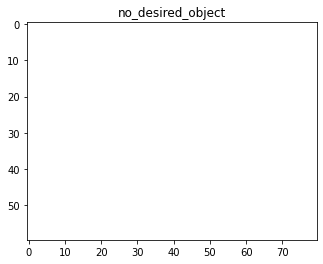

In [124]:
import numpy as np
img_float = next(representative_data_gen())
img_int8 = np.clip(np.round(x / input_scale) + input_zero_point, -128, 127).astype(np.uint8)


#interpreter = tf.lite.Interpreter(model_path="/content/person_detect_model_data.tflite")
#interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], img_int8) #p is input image 1, 96, 96, 1

interpreter.invoke()

output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])

output_data_float = np.array(output_data, dtype=np.float32)
for i in range(output_data.shape[0]):
    for j in range(output_data.shape[1]):
        output_data_float[i][j] = (output_data[i][j] - output_zero_point) * output_scale  
output_data_postprocessed = np.argmax(output_data_float, axis=-1)

print(output_data)
print(output_data_float)

print("All classes = ", list(train_generator.class_indices.keys()))
plt.imshow(img_float[0].squeeze())
plt.title(list(train_generator.class_indices.keys())[np.argmax(output_data, axis=-1)[0]])
plt.show()



# Visualize prediction using tf and tflite on images

In [180]:
import glob, cv2


pred_folder_path = "/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data_training/val/pipe"

trained_model_path = "mnv3s_23june6_60_80_3_inpUINT8_outptFLOAT32_200_epoch_90acc_.tflite"


interpreter = tf.lite.Interpreter(model_path=trained_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for img_path in glob.glob((pred_folder_path+"/*")):
    
    img = cv2.imread(img_path)
    inp_img = np.expand_dims(cv2.resize(img, (224, 224)), axis = 0)

    #tf inference
    
    pred = model.predict(inp_img)
    
    
    
    #tflite inference
    interpreter.set_tensor(input_details[0]['index'], inp_img)
    
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    black_img = np.zeros_like(img)
    
    cv2.putText(black_img, "TF " + class_names[np.argmax(pred)], (5, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(black_img, "TF " + str(np.round(np.max(pred)*100))+" %", (5, 40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    cv2.putText(black_img, "TFL " + class_names[np.argmax(output_data)], (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.putText(black_img, "TFL " + str(np.round(np.max(output_data)*100))+" %", (5, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    img_and_pred = np.concatenate((img, black_img), axis=1)
    
    cv2.imshow('Live',img_and_pred)
    key = cv2.waitKey(0) & 0xFF
    if  key == ord('Q') or key == ord('q'):
        break
    else:
        pass
    
    

cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step


In [26]:
black_img = np.zeros_like(img)
black_img.shape

(120, 160, 3)

In [20]:
arr1 = np.zeros((120, 160, 3))
arr2 = np.ones((120, 160, 3))

res = np.concatenate((arr1, arr2), axis=1)

res.shape

(120, 320, 3)

In [21]:
arr1.shape

(120, 160, 3)

In [160]:
!xxd -i ./person_detect_model_data.tflite > person_detect_model_data.cpp


In [161]:

search_text1 = "unsigned char __person_detect_model_data_tflite[]"


replace_text1 = str('#include "person_detect_model_data.h" \n\
#ifdef __has_attribute \n\
#define HAVE_ATTRIBUTE(x) __has_attribute(x) \n\
#else \n\
#define HAVE_ATTRIBUTE(x) 0 \n\
#endif \n\
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__)) \n\
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4))) \n\
#else \n\
#define DATA_ALIGN_ATTRIBUTE \n\
#endif \n\
const unsigned char g_person_detect_model_data[] DATA_ALIGN_ATTRIBUTE')


search_text2 = "unsigned int __person_detect_model_data_tflite_len"

replace_text2 = "const int g_person_detect_model_data_len"

with open(r'person_detect_model_data.cpp', 'r') as file:

    data = file.read()

    data = data.replace(search_text1, replace_text1)
    data = data.replace(search_text2, replace_text2)
  # data = data.replace(search_text2, replace_text2)

with open(r'person_detect_model_data.cpp', 'w') as file:
    file.write(data)
    file.close()



print("Text replaced")


Text replaced
